## Import libraries

In [8]:
import os
import sys
from pathlib import Path

curr_dir = Path(os.path.split(os.getcwd())[0])
utilities_dir = str(curr_dir.parent / 'utilities')

if utilities_dir not in sys.path:
	sys.path.append(utilities_dir)


In [9]:
#self made functions
import editDF as edf
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import numpy as np

#ipywidgets imports


## Import and edit datatabase from CSV

In [10]:
qadrupoleBBName = ['dataset/RQBB_100312_111212']
dipoleBBName = ['dataset/RDR_100312_101212']
dipoleMagnetName = ['dataset/RBM_100312_111212']

qadrupoleBB = edf.EditDF.readMultipleCSV(qadrupoleBBName)
dipoleBB = edf.EditDF.readMultipleCSV(dipoleBBName)
dipoleM = edf.EditDF.readMultipleCSV(dipoleMagnetName)


In [11]:
resistanceFileName = ['dataset/resistanceM', 'dataset/resistanceV6 - Copy']
timeParameterFileName = ['dataset/timeParameter1']
locationParameterFileName = ['dataset/locationParameter']

resistance = edf.EditDF.readMultipleCSV(resistanceFileName)
timeParameter = edf.EditDF.readMultipleCSV(timeParameterFileName)
locationParameter = edf.EditDF.readMultipleCSV(locationParameterFileName)
#snr = timeParameter.iloc[4:8].apply(pd.to_numeric)


## Prefilter Dateframe by rejecting invalid ramps
Find dates with current SNR bigger than the margin. These dates are then deleted from the dataframe because the ramp cannot be used for the calculation of the busbar resistance

In [12]:
#set margin for current SNR
lowMargin = 500
highMargin = 50000
#find dates with current SNR bigger than the margin and saves them into array
cutLow = edf.EditDF.smallValueDates(timeParameter.iloc[6], lowMargin)
cutHigh = edf.EditDF.smallValueDates(timeParameter.iloc[7], highMargin)
#drop invalid ramps
resistance = edf.EditDF.drop(resistance, cutLow)
resistance = edf.EditDF.drop(resistance, cutHigh)

#Invalid values
dropDates = ['2010-03-12 20:40:56.40', '2015-02-18 09:44:27.44', '2015-02-18 12:36:12.36']
resistance = edf.EditDF.drop(resistance, dropDates)

print(str(len(cutLow)) + ' invalid low ramps \n' + str(len(cutHigh)) + ' invalid high ramps')


106 invalid low ramps 
130 invalid high ramps


In [13]:
#find dates which are both in the cut array and the index
index = qadrupoleBB.columns.values
cutL = [c for c in cutLow if c in index]
cutH = [c for c in cutHigh if c in index]
cutH = [c for c in cutH if c not in cutL]
#drop invalid ramps
qadrupoleBB = edf.EditDF.drop(qadrupoleBB, cutL)
qadrupoleBB = edf.EditDF.drop(qadrupoleBB, cutH)
print(str(len(cutL)) + ' ramps filtered because of invalid low ramp \n' + str(
	len(cutH)) + ' ramps filtered because of invalid high ramp')


16 ramps filtered because of invalid low ramp 
27 ramps filtered because of invalid high ramp


In [14]:
#find dates which are both in the cut array and the index
index = dipoleBB.columns.values
cutL = [c for c in cutLow if c in index]
cutH = [c for c in cutHigh if c in index]
cutH = [c for c in cutH if c not in cutL]
#drop invalid ramps
dipoleBB = edf.EditDF.drop(dipoleBB, cutL)
dipoleBB = edf.EditDF.drop(dipoleBB, cutH)
print(str(len(cutL)) + ' ramps filtered because of invalid low ramp \n' + str(
	len(cutH)) + ' ramps filtered because of invalid high ramp')


0 ramps filtered because of invalid low ramp 
3 ramps filtered because of invalid high ramp


In [15]:
#find dates which are both in the cut array and the index
index = dipoleM.columns.values
cutL = [c for c in cutLow if c in index]
cutH = [c for c in cutHigh if c in index]
cutH = [c for c in cutH if c not in cutL]
#drop invalid ramps
dipoleM = edf.EditDF.drop(dipoleM, cutL)
dipoleM = edf.EditDF.drop(dipoleM, cutH)
print(str(len(cutL)) + ' ramps filtered because of invalid low ramp \n' + str(
	len(cutH)) + ' ramps filtered because of invalid high ramp')


13 ramps filtered because of invalid low ramp 
13 ramps filtered because of invalid high ramp


# Plot histograms

In [16]:
def histPlot(resistance, xmargin, xlabel, titel, numberOfRamps):
	""" Function plots normal histogram """
	fig, plot = plt.subplots(figsize=(7, 5))
	rOne = resistance[resistance.columns.values[0:numberOfRamps]]
	mu = np.nanmean(rOne.values)
	sigma = np.nanstd(rOne.values)
	plt.figure(1)

	values = []
	for date in range(len(resistance.columns.values[0:numberOfRamps])):
		r = resistance[resistance.columns.values[date]]
		value = [v for v in r.values]
		values += value

	n, bins, patches = plt.hist(values, 50, range=xmargin, normed=3, align='mid', alpha=0.5)

	y = mlab.normpdf(bins, mu, sigma)
	plt.plot(bins, y, 'r--', linewidth=2)
	plt.xlabel(xlabel)
	plt.title(titel)
	print('mu=' + str(mu) + ' sigma=' + str(sigma))

def spliceAproxHist(resistance, xmargin, xlabel, titel, numberOfRamps, avgSpliceNum, leftCut, rightCut):
	""" Function aproximates splice range and plots histogram """
	fig, plot = plt.subplots(figsize=(7, 5))
	rOne = resistance[resistance.columns.values[1:numberOfRamps]]
	mu = np.nanmean(rOne.values)
	sigma = np.nanstd(rOne.values)
	plt.figure(1)

	small = mu - leftCut * sigma
	big = mu + rightCut * sigma
	print('Used range: [' + str(small) + ',' + str(big) + ']')
	values = []
	for date in range(len(resistance.columns.values[1:numberOfRamps])):
		r = resistance[resistance.columns.values[date]]
		rOneA = r[r.values < big]
		rOneB = rOneA[rOneA.values > small]

		value = np.zeros(len(rOneB.values))
		value = [v / avgSpliceNum for v in rOneB.values]
		values += value

	muS = np.nanmean(values)
	sigmaS = np.nanstd(values)

	plt.xlabel(xlabel)
	plt.title(titel)
	nF, binsF, patchesF = plt.hist(values, 50, range=xmargin, normed=1, align='mid', alpha=0.5)
	yF = mlab.normpdf(binsF, muS, sigmaS)
	plt.plot(binsF, yF, 'r--', linewidth=2)

	print('mu=' + str(muS) + ' sigma=' + str(sigmaS))


## Quadrupole splice resistance aproximation

Used range: [1.11582573437e-09,4.75401537737e-09]


/usr/local/lib/swan/ipykernel/__main__.py:38: RuntimeWarning: invalid value encountered in less


mu=3.48957941635e-10 sigma=5.22030989862e-11


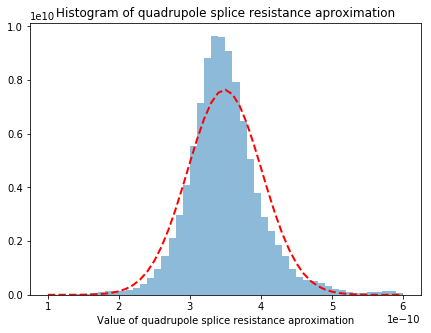

In [17]:
xmargin = [1e-10, 6e-10]
xlabel = 'Value of quadrupole splice resistance aproximation'
titel = 'Histogram of quadrupole splice resistance aproximation'
numberOfRamps = 600
avgSpliceNum = 8
#from table of standart diviation 
leftCut = 1.75  #*sigma (5%)
rightCut = 1.645  #*sigma (4%)

spliceAproxHist(resistance, xmargin, xlabel, titel, numberOfRamps, avgSpliceNum, leftCut, rightCut)


Used range: [1.12107630945e-09,4.88468187792e-09]


/usr/local/lib/swan/ipykernel/__main__.py:38: RuntimeWarning: invalid value encountered in less


mu=3.57041843672e-10 sigma=5.63065144621e-11


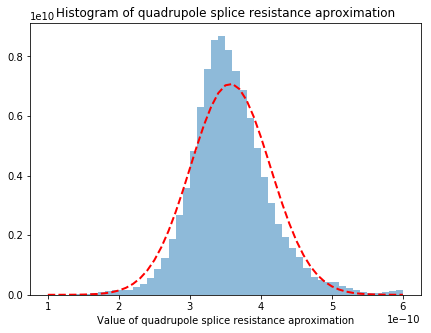

In [18]:
xmargin = [1e-10, 6e-10]
xlabel = 'Value of quadrupole splice resistance aproximation'
titel = 'Histogram of quadrupole splice resistance aproximation'
numberOfRamps = 600
avgSpliceNum = 8
#from table of standart diviation 
leftCut = 1.75  #*sigma (5%)
rightCut = 1.645  #*sigma (4%)

spliceAproxHist(qadrupoleBB, xmargin, xlabel, titel, numberOfRamps, avgSpliceNum, leftCut, rightCut)


## Dipole busbar splice resistance aproximation

Used range: [-4.12554373572e-10,1.7175463368e-09]
mu=3.12896110109e-10 sigma=8.93331175082e-11


/usr/local/lib/swan/ipykernel/__main__.py:38: RuntimeWarning: invalid value encountered in less


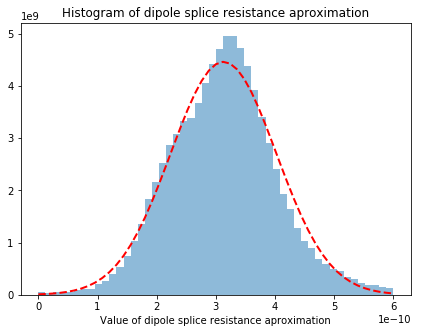

In [19]:
xmargin = [0, 6e-10]
xlabel = 'Value of dipole splice resistance aproximation'
titel = 'Histogram of dipole splice resistance aproximation'
numberOfRamps = 95
avgSpliceNum = 2.77
#from table of standart diviation 
leftCut = 4  #*sigma (0%)
rightCut = 2.575  #*sigma (0.5%)

spliceAproxHist(dipoleBB, xmargin, xlabel, titel, numberOfRamps, avgSpliceNum, leftCut, rightCut)


## Dipole magent

Used range: [-1.24658483438e-07,1.41186452017e-07]


/usr/local/lib/swan/ipykernel/__main__.py:38: RuntimeWarning: invalid value encountered in less


mu=8.05324036568e-09 sigma=7.72602049064e-09


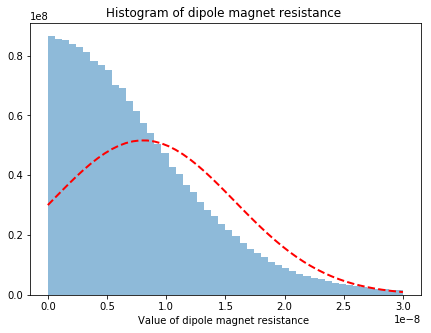

In [20]:
xmargin = [0, 3e-8]
xlabel = 'Value of dipole magnet resistance '
titel = 'Histogram of dipole magnet resistance '
numberOfRamps = 500
avgSpliceNum = 1
#from table of standart diviation 
leftCut = 10
rightCut = 10

spliceAproxHist(dipoleM, xmargin, xlabel, titel, numberOfRamps, avgSpliceNum, leftCut, rightCut)
